# Library

In [1]:
import os
import glob
import numpy as np
from astropy.table import Table
from ccdproc import ImageFileCollection
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams["savefig.dpi"] = 500
mpl.rcParams["xtick.labelsize"] = 14  # X축 틱의 글자 크기 설정
mpl.rcParams["ytick.labelsize"] = 14  # Y축 틱의 글자 크기 설정
plt.rc("font", family="serif")

In [3]:
def makeSpecColors(n, palette='Spectral'):
	#	Color palette
	import seaborn as sns
	palette = sns.color_palette(palette, as_cmap=True,)
	palette.reversed

	clist_ = [palette(i) for i in range(palette.N)]
	cstep = int(len(clist_)/n)
	clist = [clist_[i*cstep] for i in range(n)]
	return clist

In [4]:
wavelengths= np.arange(4000, 8875+125, 125)

wfilters = ['m375w', 'm425w']
mfilters = [f"m{str(center_lam)[0:3]}" for center_lam in wavelengths]
mcolors = np.array(makeSpecColors(len(mfilters)))[::-1]
mlamarr = np.array([float(filte[1:]) for filte in mfilters])
bfilters = ['u', 'g', 'r', 'i', 'z']
filter_color_palette_dict = {
	'u': 'blue',
	'g': 'green',
	'r': 'tomato',
	'i': 'crimson',
	'z': 'purple',
	'm375w': 'cyan',
	'm425w': 'dodgerblue',
}

filters = mfilters+bfilters+wfilters

for filte, c in zip(mfilters, mcolors):
	filter_color_palette_dict[filte] = c

In [5]:
path_data = '/lyman/data1/processed_1x1_gain2750'
# path_data = '/lyman/data1/processed'
path_save = '/lyman/data1/Commission'

In [6]:
columns_to_pick = [
    # "file", "naxis", "naxis1", "naxis2", "mjd-obs", "ctype1", "cunit1", "crval1", 
    # "file", "naxis", "naxis1", "naxis2", "ctype1", "cunit1", "crval1", 
    "file",
    # "crpix1", "cd1_1", "cd1_2", "ctype2", "cunit2", "crval2", "crpix2", "cd2_1", 
    # "crpix1", "cd1_1", "cd1_2", 
    # "cd1_1", "cd1_2", 
    "cd1_2", 
    # "cd2_2", "exptime", "gain", "saturate", "date", "object", "egain", "filter", 
    "cd2_2", "exptime", "gain", "date", "object", "egain", "filter", 
    "date-obs", "date-loc", "exposure", "centalt", "centaz", "airmass", "mjd", 
    "jd", "seeing", "peeing", "ellip", "elong", "skysig", "skyval", "refcat", 
    "maglow", "magup", "stdnumb", "auto", "aper", "aper_1", "aper_2", "aper_3", 
    "aper_4", "aper_5", "zp_auto", "ezp_auto", "ul3_auto", "ul5_auto", "zp_0", 
    "ezp_0", "ul3_0", "ul5_0", "zp_1", "ezp_1", "ul3_1", "ul5_1", "zp_2", "ezp_2", 
    "ul3_2", "ul5_2", "zp_3", "ezp_3", "ul3_3", "ul5_3", "zp_4", "ezp_4", "ul3_4", 
    "ul5_4", "zp_5", "ezp_5", "ul3_5", "ul5_5",
]
print(f"{len(columns_to_pick)} columns selected")

62 columns selected


In [7]:
keys_to_check = ['seeing', 'ul5_1', 'ellip', 'skyval', 'skysig', 'airmass']

# Initial Setting

In [8]:
n_sigma = 1

In [209]:
# obj = 'PSZ2G227.44-31.24'
# obj = 'Gcluster_Shim'
obj = 'T00138'

#	Abell
# obj = 'T03206'
# obj = 'T03207'
# obj = 'T03208'
# obj = 'T03363'
# obj = 'T03364'
# obj = 'T03365'
# obj = 'T03524'
# obj = 'T03525'
obj = 'T03526'

# Data

- Units

In [210]:
units = [os.path.basename(folder) for folder in sorted(glob.glob(f"{path_data}/{obj}/7DT*"))]
print(f"{len(units)} Units: {units}")

13 Units: ['7DT02', '7DT03', '7DT04', '7DT05', '7DT07', '7DT08', '7DT09', '7DT10', '7DT11', '7DT12', '7DT13', '7DT14', '7DT15']


- Filters

In [211]:
# filters = list(np.unique([os.path.basename(folder) for folder in sorted(glob.glob(f"{path_data}/{obj}/*/*"))]))
filters = list(np.unique([os.path.basename(folder) for folder in sorted(glob.glob(f"{path_data}/{obj}/7DT??/*"))]))
print(f"{len(filters)} Filters: {filters}")

22 Filters: ['g', 'm400', 'm425', 'm450', 'm475', 'm500', 'm525', 'm550', 'm575', 'm600', 'm625', 'm650', 'm675', 'm700', 'm725', 'm750', 'm775', 'm800', 'm825', 'm850', 'm875', 'r']


# Select

In [212]:
filte = 'm400'
color = filter_color_palette_dict[filte]

In [213]:
path_output = f"{path_save}/{obj}/{filte}"

if not os.path.exists(path_output):
	os.makedirs(path_output)

In [214]:
images = sorted(glob.glob(f"{path_data}/{obj}/*/{filte}/calib*0.fits"))
print(f"{len(images)} images found")

3 images found


In [215]:
ic = ImageFileCollection(filenames=images)
# raw_table = ic.summary[*columns_to_pick]

In [216]:
raw_table = ic.summary[columns_to_pick]

In [217]:
raw_table.write(f"{path_output}/header.csv", format='csv', overwrite=True)

In [218]:
# ic = ImageFileCollection(filenames=images)
# raw_table = ic.summary[*columns_to_pick]

bad_image_mask = ~raw_table['cd1_2'].mask
table = raw_table[~raw_table['cd1_2'].mask]

print(f"All  images: {len(raw_table)}")
print(f"Bad  images: {len(raw_table[~bad_image_mask])}")
print(f"Good images: {len(table)}")

All  images: 3
Bad  images: 0
Good images: 3


In [219]:
for key in keys_to_check:
	table[key] = table[key].filled(np.nan).astype(float)

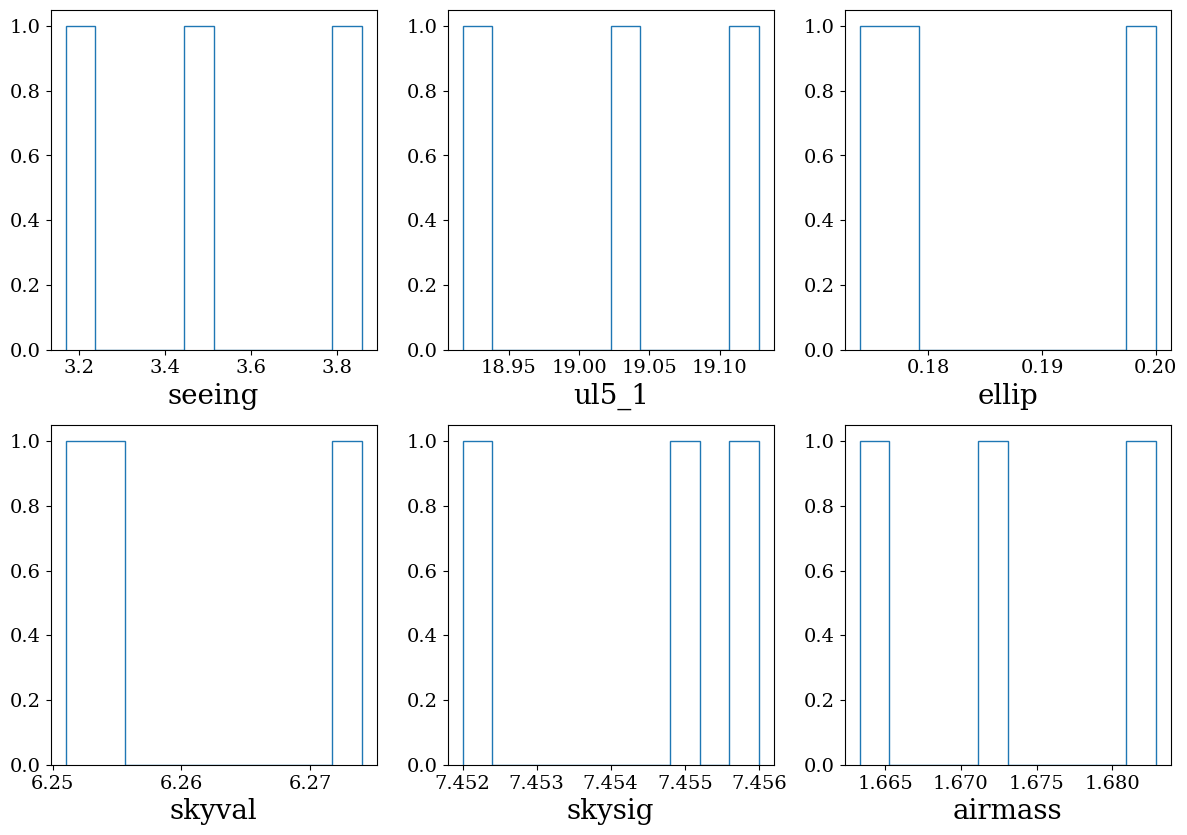

In [220]:
plt.figure(figsize=(12, 12))
for kk, key in enumerate(keys_to_check):
    plt.subplot(3, 3, kk + 1)  # 1부터 인덱스를 시작하기 위해 kk + 1
    plt.hist(table[key], histtype='step')       # 히스토그램 그리기
    plt.xlabel(key)            # x축 레이블 추가
plt.tight_layout()
plt.show()

Text(0, 0.5, 'seeing')

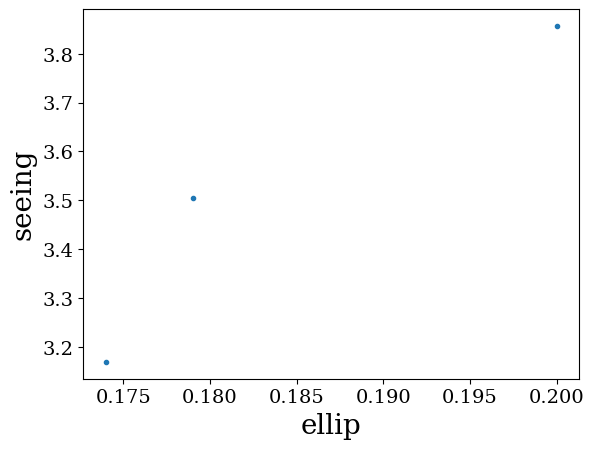

In [221]:
plt.plot(table['ellip'], table['seeing'], '.')
plt.xlabel('ellip')
plt.ylabel('seeing')
# Positive correlation

In [222]:
seeing_median = np.nanmedian(table['seeing'])
seeing_std = np.nanstd(table['seeing'])
seeing_min = np.nanmin(table['seeing'])
seeing_max = np.nanmax(table['seeing'])

depth_median = np.nanmedian(table['ul5_1'])
depth_std = np.nanstd(table['ul5_1'])
depth_min = np.nanmin(table['ul5_1'])
depth_max = np.nanmax(table['ul5_1'])

print(f"Seeing Median Value: {seeing_median:.3f} +/- {seeing_std:.3f}")
print(f"Depth  Median Value: {depth_median:.3f} +/- {depth_std:.3f}")

Seeing Median Value: 3.505 +/- 0.281
Depth  Median Value: 19.025 +/- 0.086


In [223]:
mosaic = """
SSSx
MMMD
MMMD
MMMD
"""

In [224]:
indx_median = (table['seeing'] < seeing_median) & (table['ul5_1'] > depth_median)
indx_nsigma = (table['seeing'] < seeing_median + seeing_std) & (table['ul5_1'] > depth_median - depth_std)

n_median_select = len(table[indx_median])
n_nsigma_select = len(table[indx_nsigma])

print(f"Median Select : {n_median_select}")
print(f"{n_sigma} Sigma Select: {n_nsigma_select}")

Median Select : 1
1 Sigma Select: 2


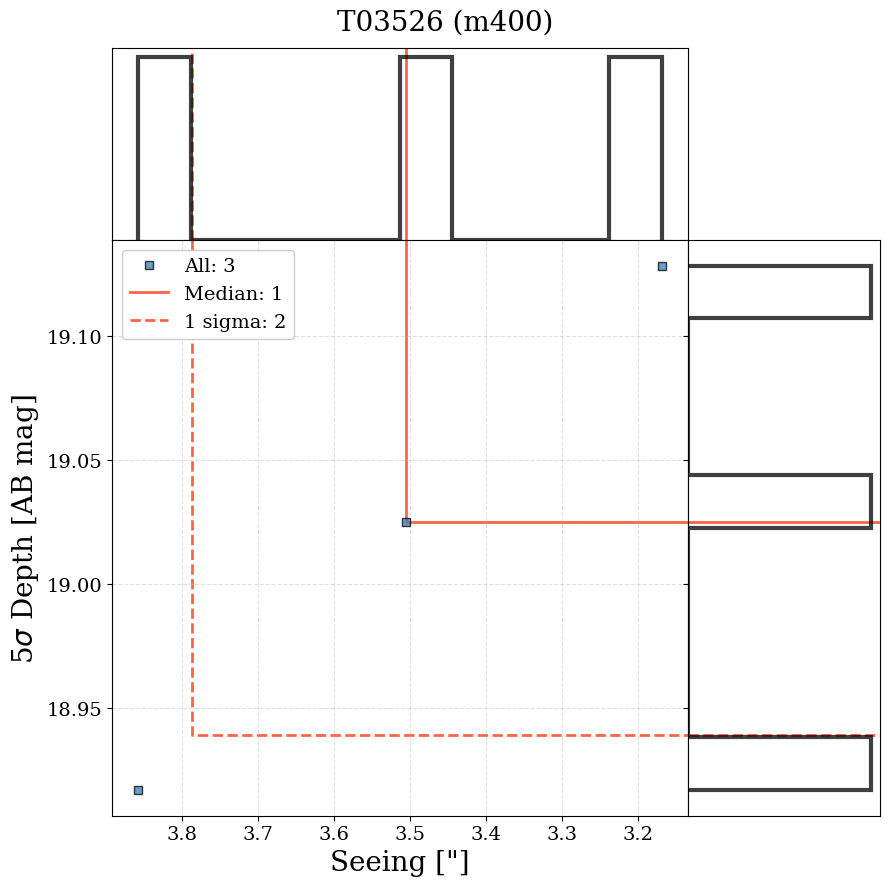

In [225]:
fig, ax = plt.subplot_mosaic(
	mosaic, figsize = (9, 9),
	empty_sentinel = "x",
	gridspec_kw = dict(
		# width_ratios=[1, 2, 2], height_ratios=[1, 2],
		wspace = 0.0, hspace = 0.0,
		)
	)
# = = = = = = = = = = = = = = = = = = = =
#	Main Axe
# - - - - - - - - - - - - - - - - - - - - 
ax["M"].plot(table['seeing'], table['ul5_1'], 's', c=color, mec='k', alpha=0.75, label=f'All: {len(table)}')
# ax["M"].axvspan(xmin=seeing_median-seeing_std*n_sigma, xmax=seeing_median+seeing_std*n_sigma, color='tomato', alpha=0.1, zorder=0)
# ax["M"].axvline(seeing_median, color='tomato', zorder=1)
# ax["M"].axhspan(ymin=depth_median-depth_std*n_sigma, ymax=depth_median+depth_std*n_sigma, color='tomato', alpha=0.1, zorder=0)
# ax["M"].axhline(depth_median, color='tomato', zorder=1)
# - - - - - - - - - - - - - - - - - - - - 
xl, xr = ax["M"].set_xlim()
yl, yu = ax["M"].set_ylim()
# - - - - - - - - - - - - - - - - - - - - 
ax["M"].plot([seeing_median, seeing_median, xl], [yu, depth_median, depth_median], color='tomato', zorder=0, lw=2, label=f"Median: {n_median_select}")
ax["M"].plot([seeing_median+seeing_std, seeing_median+seeing_std, xl], [yu, depth_median-depth_std, depth_median-depth_std], color='tomato', zorder=0, lw=2, ls='--', label=f"{n_sigma} sigma: {n_nsigma_select}")
# - - - - - - - - - - - - - - - - - - - - 
ax["M"].set_xlim([xr, xl])
ax["M"].set_xlabel("""Seeing ["]""")
ax["M"].set_ylabel(r'5$\sigma$ Depth [AB mag]')
ax["M"].grid('both', ls='--', alpha=0.5, color='silver', zorder=0)

ax["M"].legend(loc='upper left', fontsize=14, framealpha=1.0)
# = = = = = = = = = = = = = = = = = = = =
#	Seeing Axe
# - - - - - - - - - - - - - - - - - - - - 
ax["S"].hist(table['seeing'], color='k', histtype='step', lw=3, alpha=0.75)
# ax["S"].axvspan(xmin=seeing_median-seeing_std*n_sigma, xmax=seeing_median+seeing_std*n_sigma, color='tomato', alpha=0.1, zorder=0)
ax["S"].axvline(seeing_median, color='tomato', zorder=1, lw=2)
ax["S"].axvline(seeing_median+seeing_std, color='tomato', zorder=0, lw=2, ls='--')

ax["S"].set_xlim([xr, xl])
ax["S"].set_yticks([])
# = = = = = = = = = = = = = = = = = = = =
#	Depth Axe
# - - - - - - - - - - - - - - - - - - - - 
ax["D"].hist(table['ul5_1'], color='k', histtype='step', lw=3, alpha=0.75, orientation='horizontal')
ax["D"].axhline(depth_median, color='tomato', zorder=1, lw=2)
ax["D"].axhline(depth_median-depth_std, color='tomato', zorder=0, lw=2, ls='--')

# ax["D"].axhspan(ymin=depth_median-depth_std*n_sigma, ymax=depth_median+depth_std*n_sigma, color='tomato', alpha=0.1, zorder=0)
ax["D"].set_ylim([yl, yu])
ax["D"].set_xticks([])
# = = = = = = = = = = = = = = = = = = = =
# Remove tick labels for cleaner look
ax["S"].tick_params(labelbottom=False)
ax["D"].tick_params(labelleft=False)

plt.suptitle(f"{obj} ({filte})", fontsize=20)
fig.tight_layout()

fig.savefig(f"{path_output}/select.png",)

# Save

In [226]:
# f = open(f"{path_output}/select_median.txt", "w")
# for inim in table['file'][indx_median].data:
# 	f.write(f"{inim}\n")
# f.close()

In [227]:
# g = open(f"{path_output}/select_{n_sigma}sigma.txt", "w")
# for inim in table['file'][indx_nsigma].data:
# 	g.write(f"{inim}\n")
# g.close()

# Iteration

## Functions

In [228]:
def get_seeing_depth_stat(table, verbose=False):

	# NaN 값을 무시하고 계산하도록 수정
	seeing_median = np.nanmedian(table['seeing'])
	seeing_std = np.nanstd(table['seeing'])
	seeing_min = np.nanmin(table['seeing'])
	seeing_max = np.nanmax(table['seeing'])

	depth_median = np.nanmedian(table['ul5_1'])
	depth_std = np.nanstd(table['ul5_1'])
	depth_min = np.nanmin(table['ul5_1'])
	depth_max = np.nanmax(table['ul5_1'])

	if verbose:
		print(f"Seeing Median Value: {seeing_median:.3f} +/- {seeing_std:.3f}")
		print(f"Depth  Median Value: {depth_median:.3f} +/- {depth_std:.3f}")
	
	return (seeing_median, seeing_std, seeing_min, seeing_max, depth_median, depth_std, depth_min, depth_max)

In [229]:
def plot_seeing_depth_histogram(table, seeing_median, depth_median, n_sigma, 
                                n_median_select, n_nsigma_select, obj, filte, 
                                path_output, color='k'):
    mosaic = """
    SSSx
    MMMD
    MMMD
    MMMD
    """
    
    fig, ax = plt.subplot_mosaic(
        mosaic, figsize=(9, 9),
        empty_sentinel="x",
        gridspec_kw=dict(
            wspace=0.0, hspace=0.0,
        )
    )
    
    # Main Axe
    ax["M"].plot(table['seeing'], table['ul5_1'], 's', c=color, mec='k', alpha=0.75, label=f'All: {len(table)}')
    
    xl, xr = ax["M"].set_xlim()
    yl, yu = ax["M"].set_ylim()
    
    ax["M"].plot([seeing_median, seeing_median, xl], [yu, depth_median, depth_median], color='tomato', zorder=0, lw=2, label=f"Median: {n_median_select}")
    ax["M"].plot([seeing_median+seeing_std, seeing_median+seeing_std, xl], [yu, depth_median-depth_std, depth_median-depth_std], color='tomato', zorder=0, lw=2, ls='--', label=f"{n_sigma} sigma: {n_nsigma_select}")
    
    ax["M"].set_xlim([xr, xl])
    ax["M"].set_xlabel("""Seeing ["]""")
    ax["M"].set_ylabel(r'5$\sigma$ Depth [AB mag]')
    ax["M"].grid('both', ls='--', alpha=0.5, color='silver', zorder=0)
    ax["M"].legend(loc='upper left', fontsize=14, framealpha=1.0)
    
    # Seeing Axe
    ax["S"].hist(table['seeing'], color='k', histtype='step', lw=3, alpha=0.75)
    ax["S"].axvline(seeing_median, color='tomato', zorder=1, lw=2)
    ax["S"].axvline(seeing_median+seeing_std, color='tomato', zorder=0, lw=2, ls='--')
    ax["S"].set_xlim([xr, xl])
    ax["S"].set_yticks([])
    
    # Depth Axe
    ax["D"].hist(table['ul5_1'], color='k', histtype='step', lw=3, alpha=0.75, orientation='horizontal')
    ax["D"].axhline(depth_median, color='tomato', zorder=1, lw=2)
    ax["D"].axhline(depth_median-depth_std, color='tomato', zorder=0, lw=2, ls='--')
    ax["D"].set_ylim([yl, yu])
    ax["D"].set_xticks([])
    
    # Remove tick labels for cleaner look
    ax["S"].tick_params(labelbottom=False)
    ax["D"].tick_params(labelleft=False)
    
    # Add a title
    plt.suptitle(f"{obj} ({filte})", fontsize=20)
    fig.tight_layout()

    # Save the figure
    fig.savefig(f"{path_output}/select.png")


## Main

In [230]:
result_table = Table()
result_table['filter'] = filters
#	Number of Images
result_table['n_all'] = 0
result_table['n_bad'] = 0
result_table['n_image'] = 0
result_table['n_select_median'] = 0
result_table['n_select_nsigma'] = 0
#	Stats
result_table['seeing_median'] = 0.
result_table['seeing_std'] = 0.
result_table['seeing_min'] = 0.
result_table['seeing_max'] = 0.
result_table['depth_median'] = 0.
result_table['depth_std'] = 0.
result_table['depth_min'] = 0.
result_table['depth_max'] = 0.

In [231]:
verbose = False

20it [00:23,  1.23s/it]/tmp/ipykernel_4124481/663126416.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplot_mosaic(
22it [00:25,  1.18s/it]


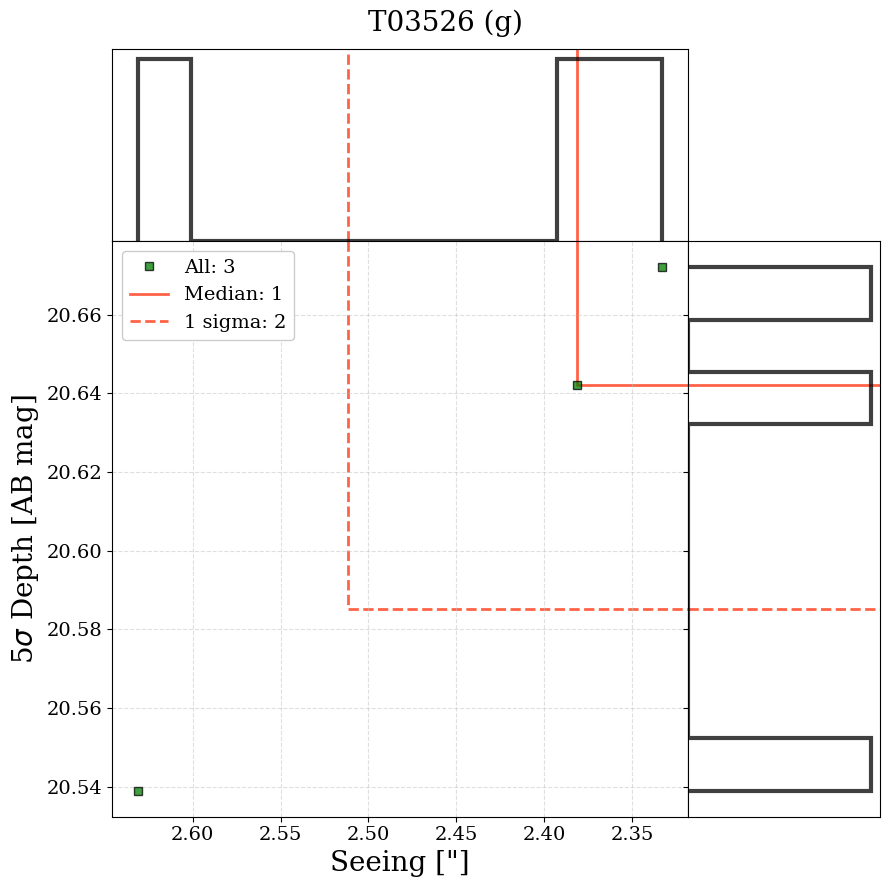

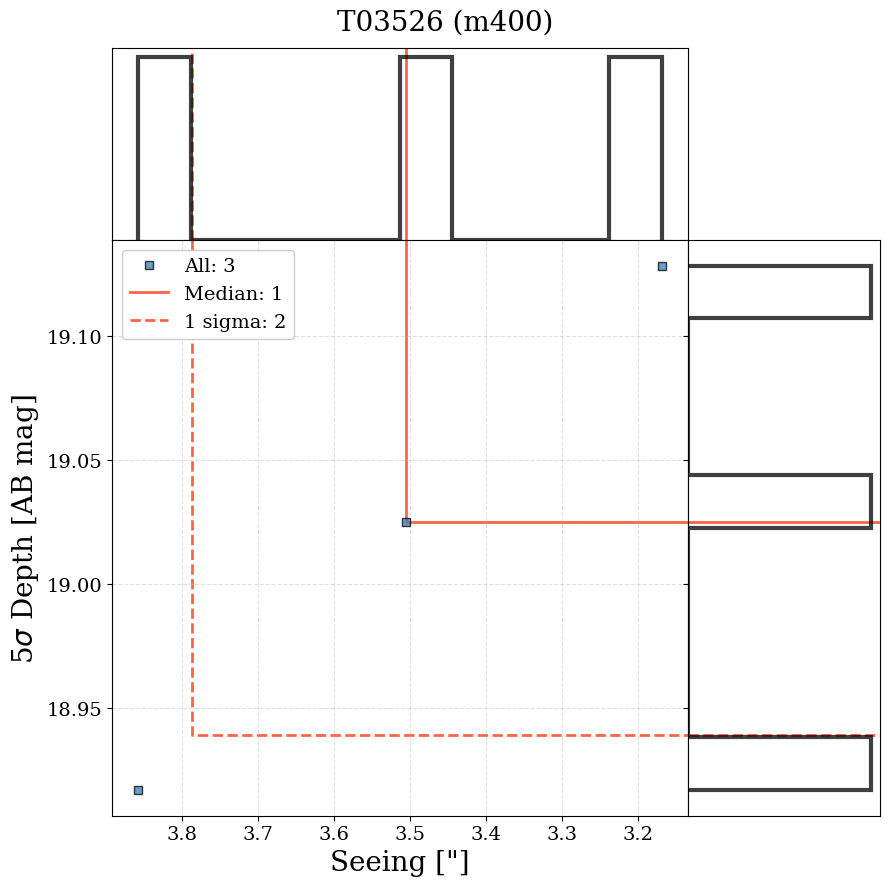

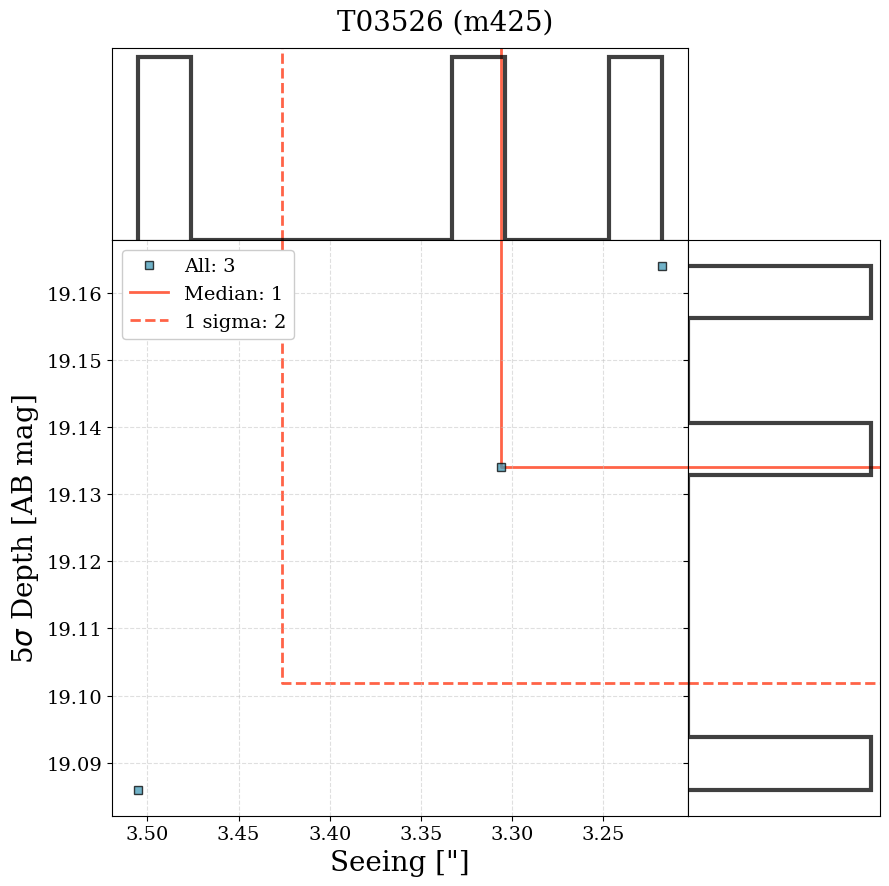

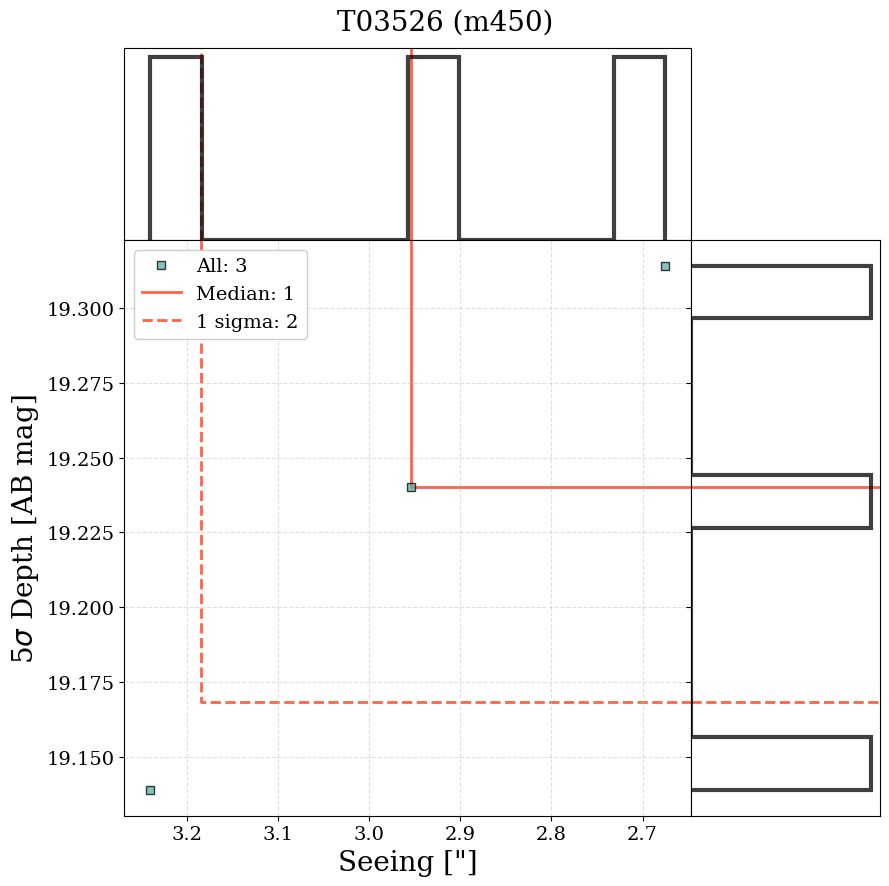

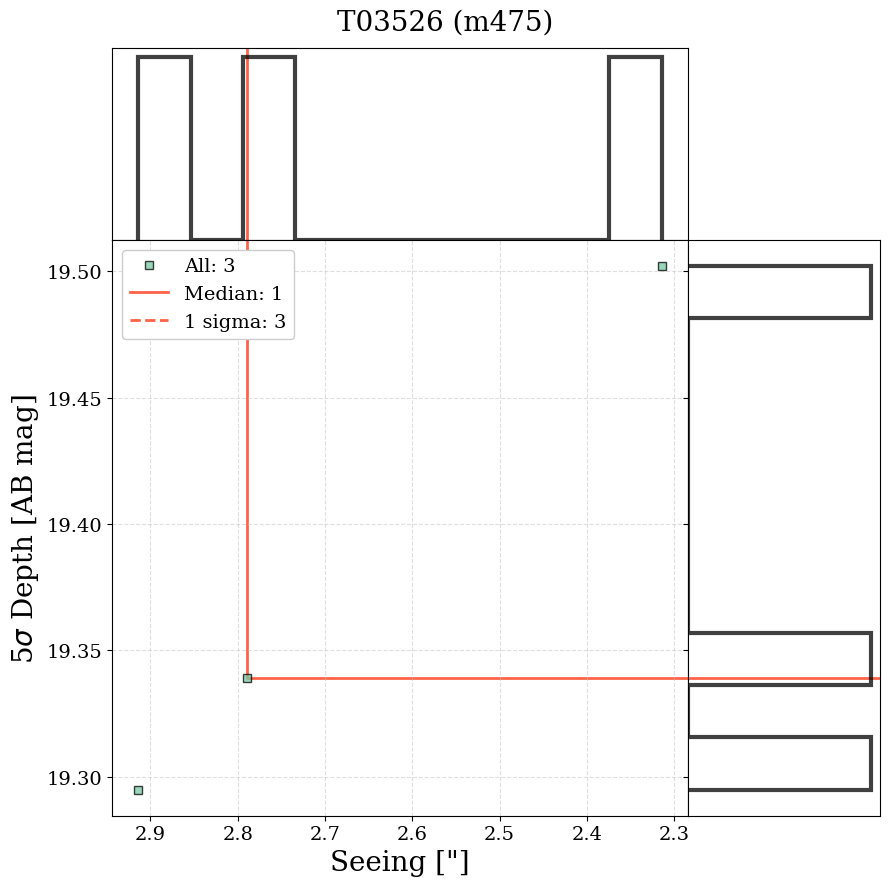

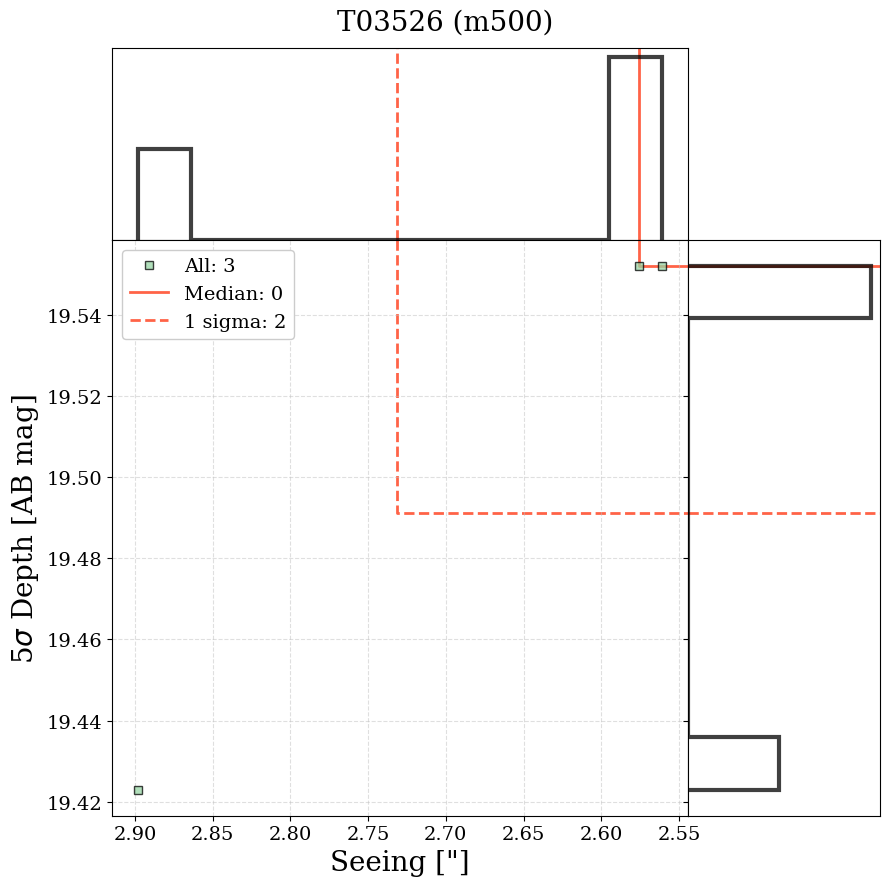

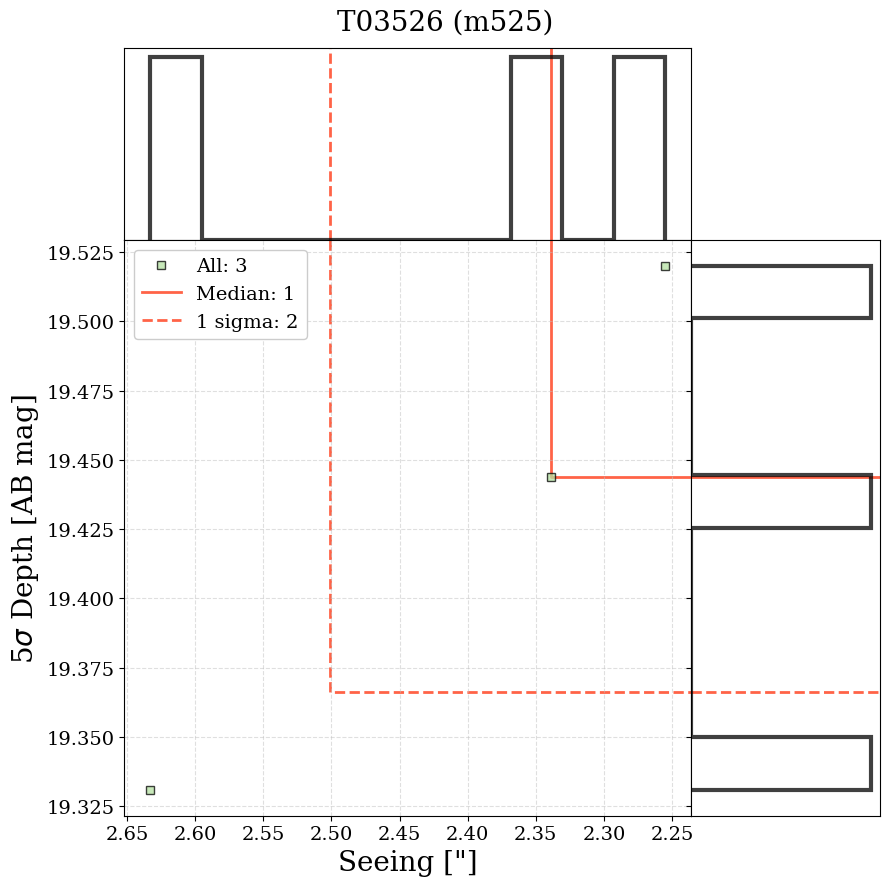

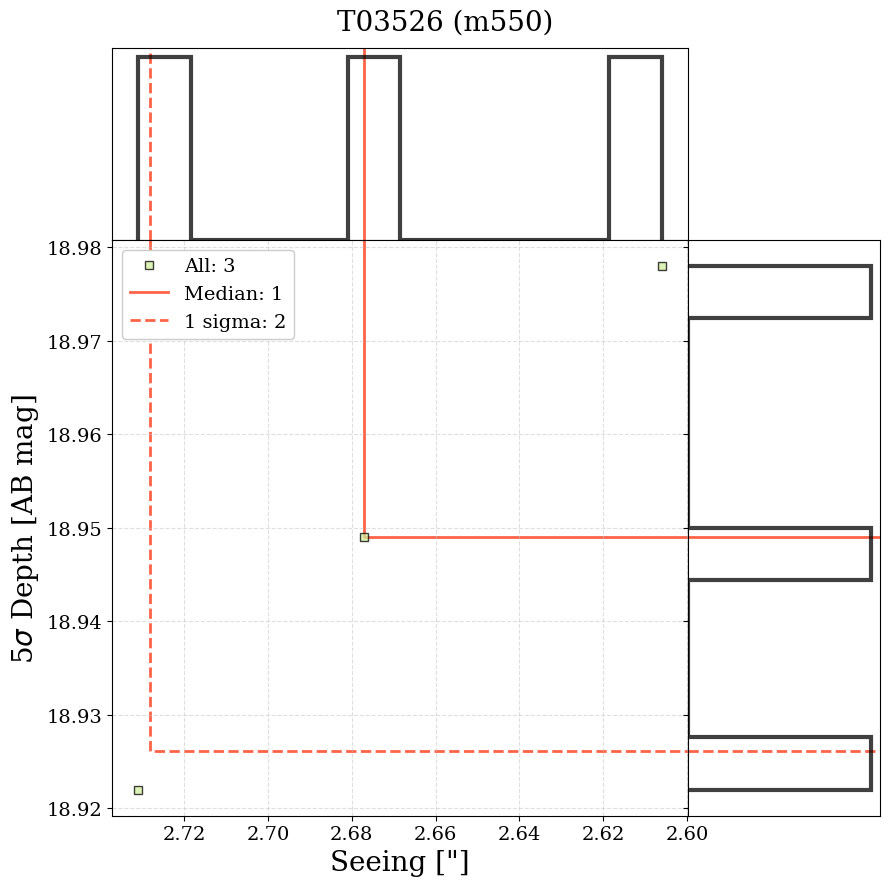

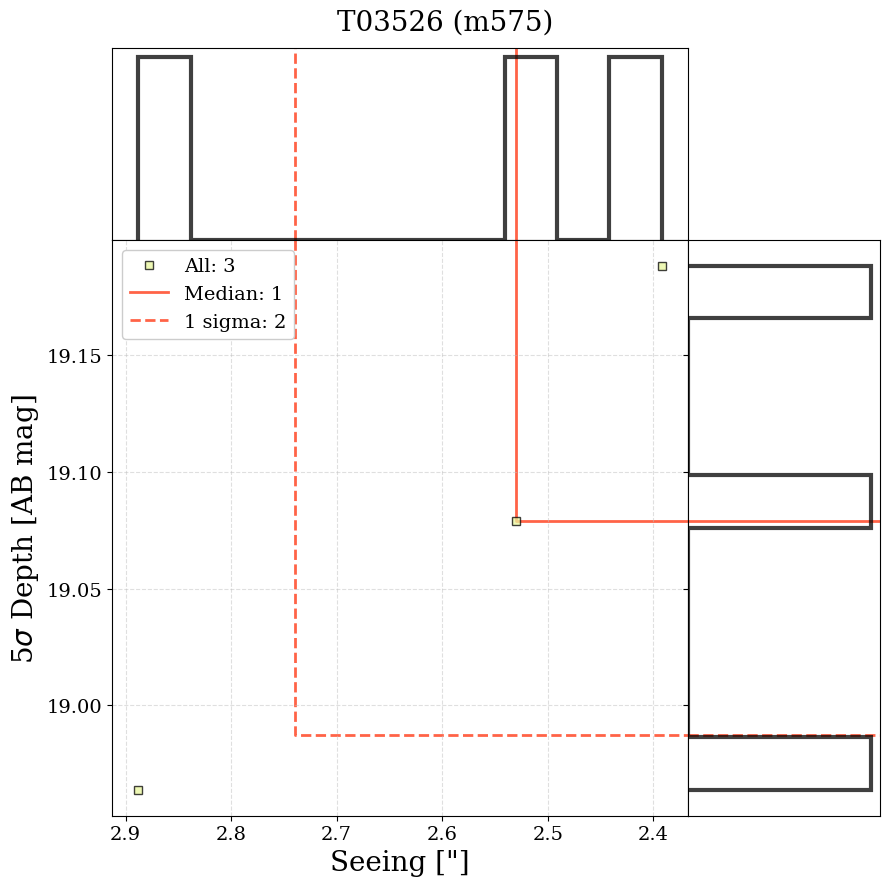

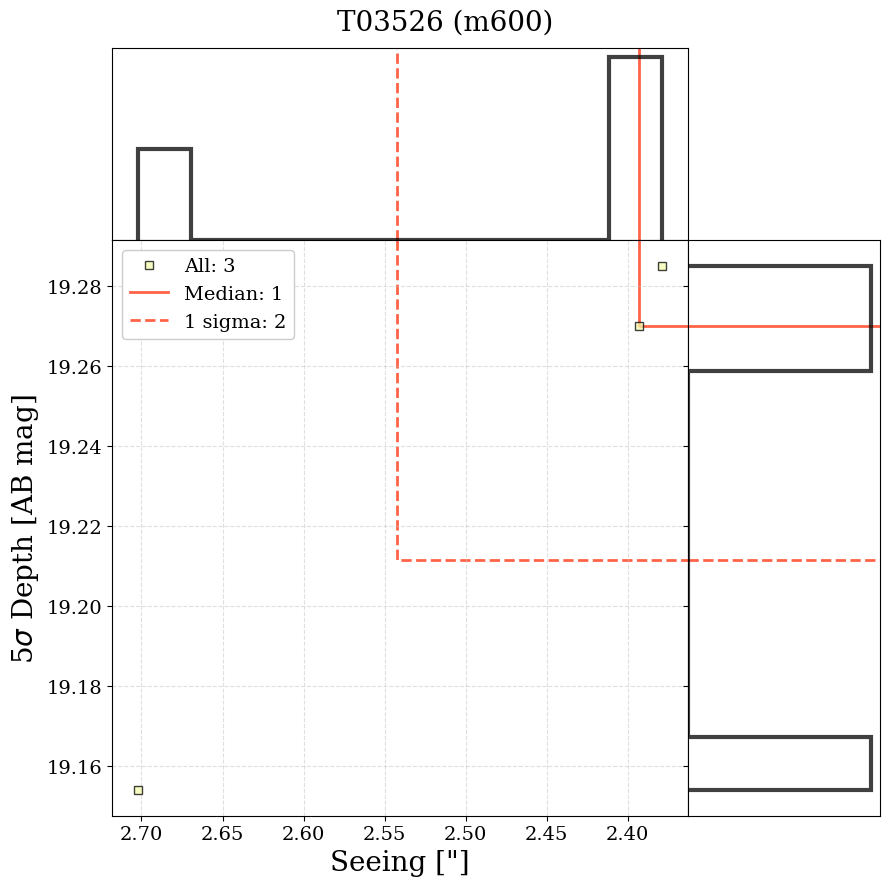

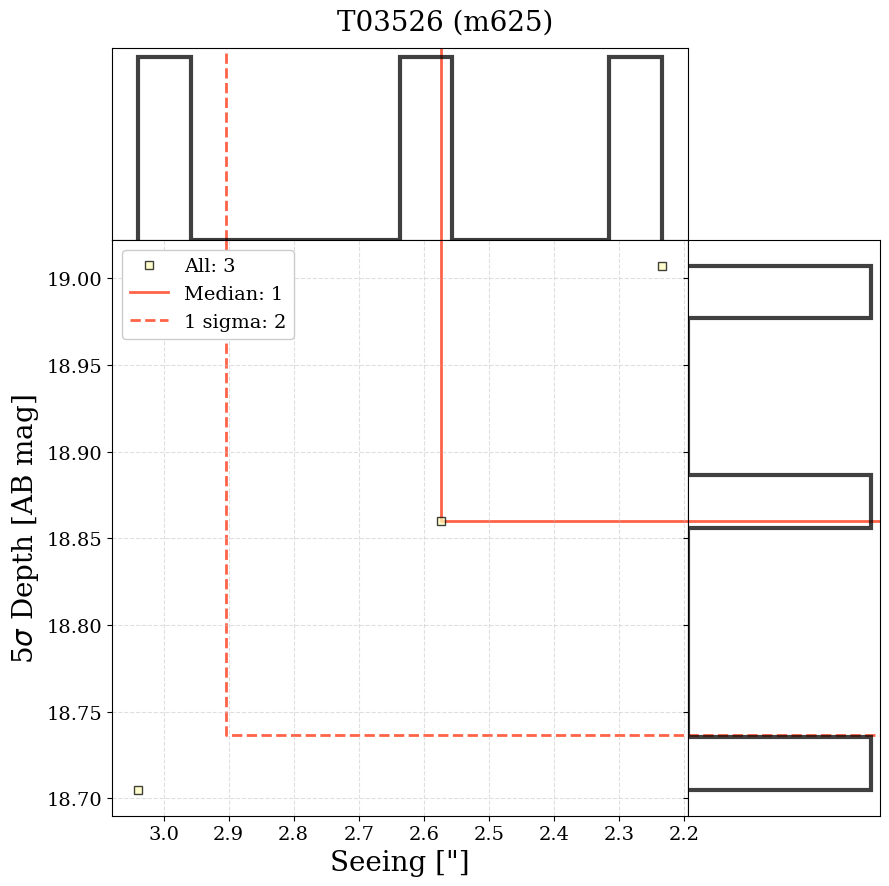

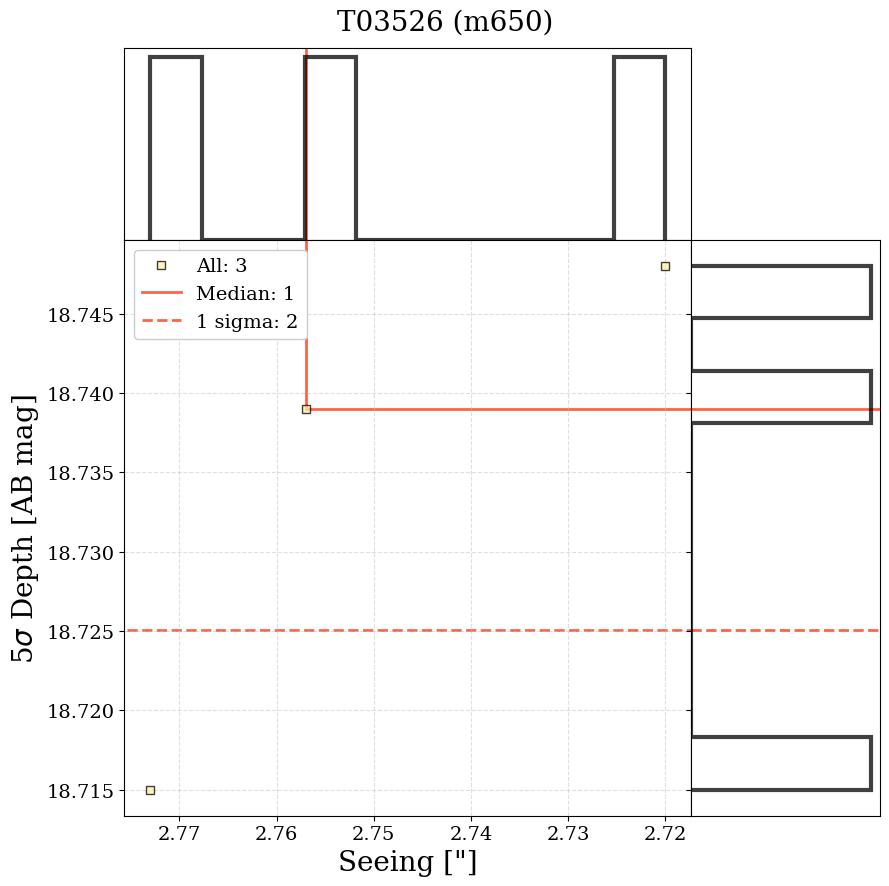

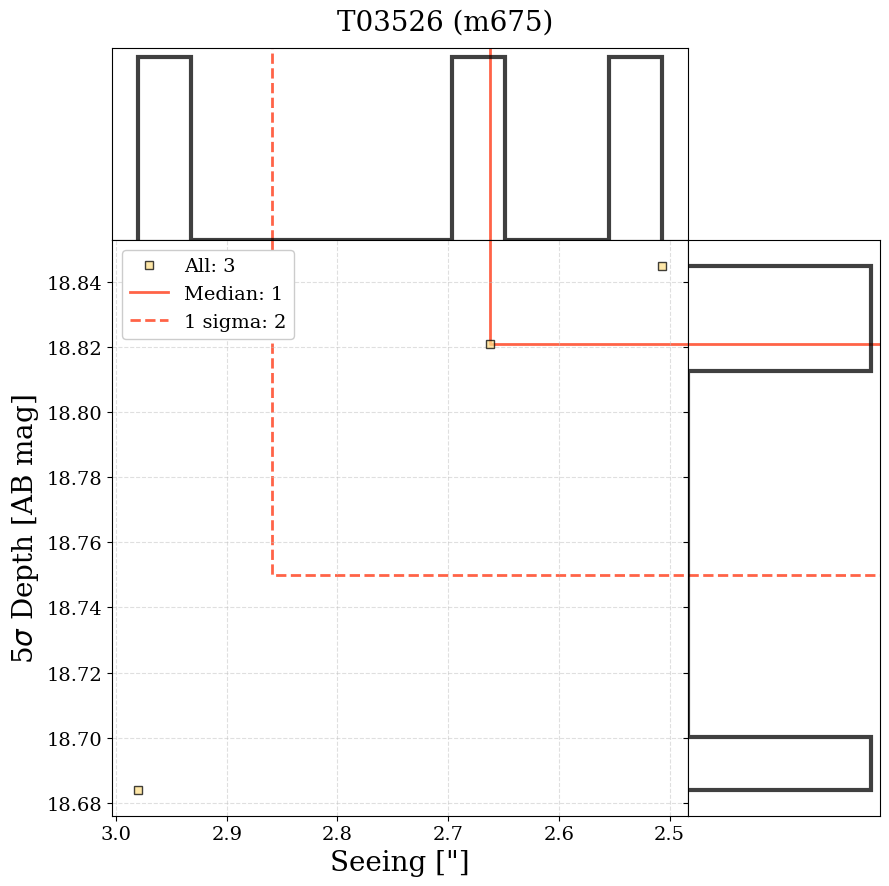

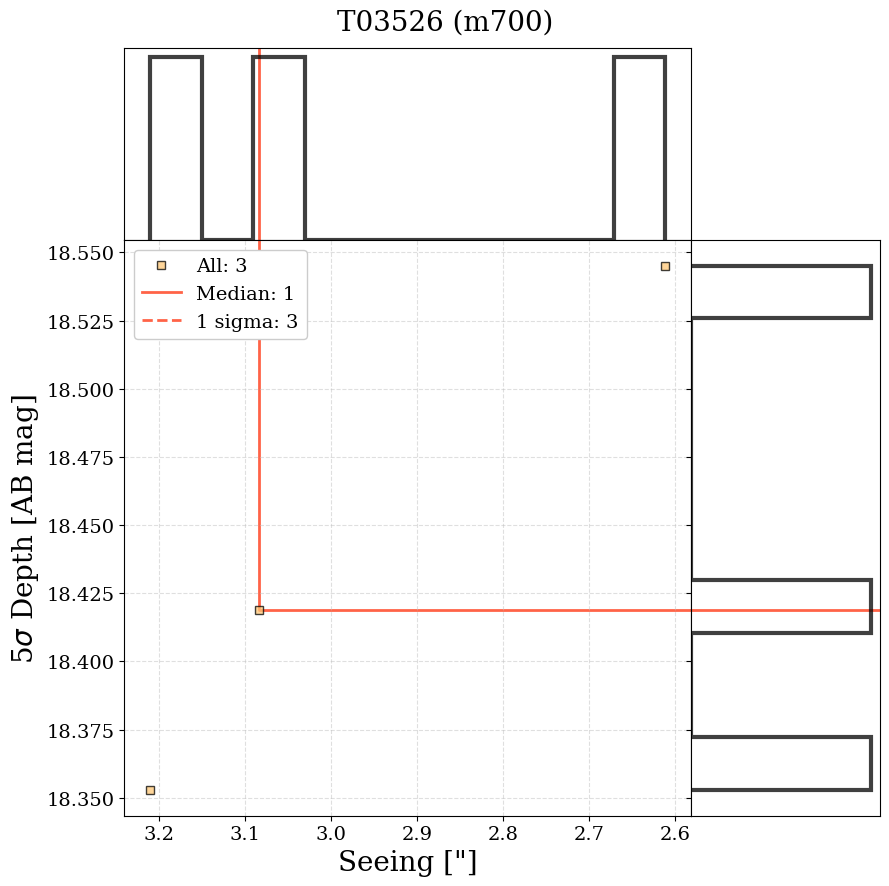

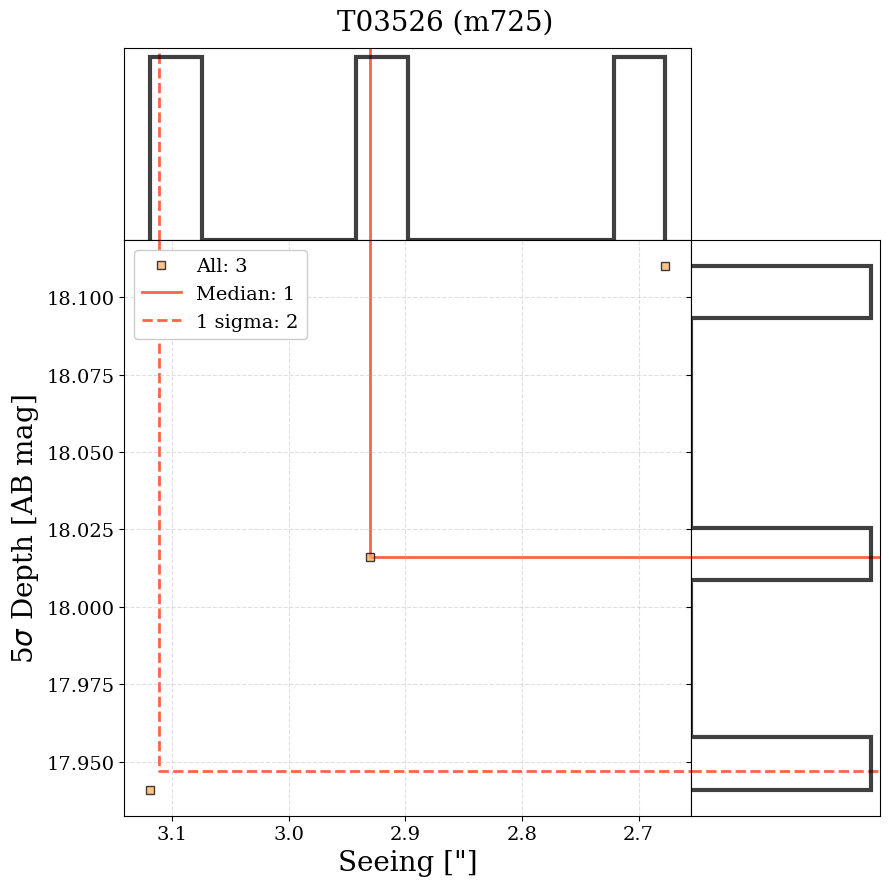

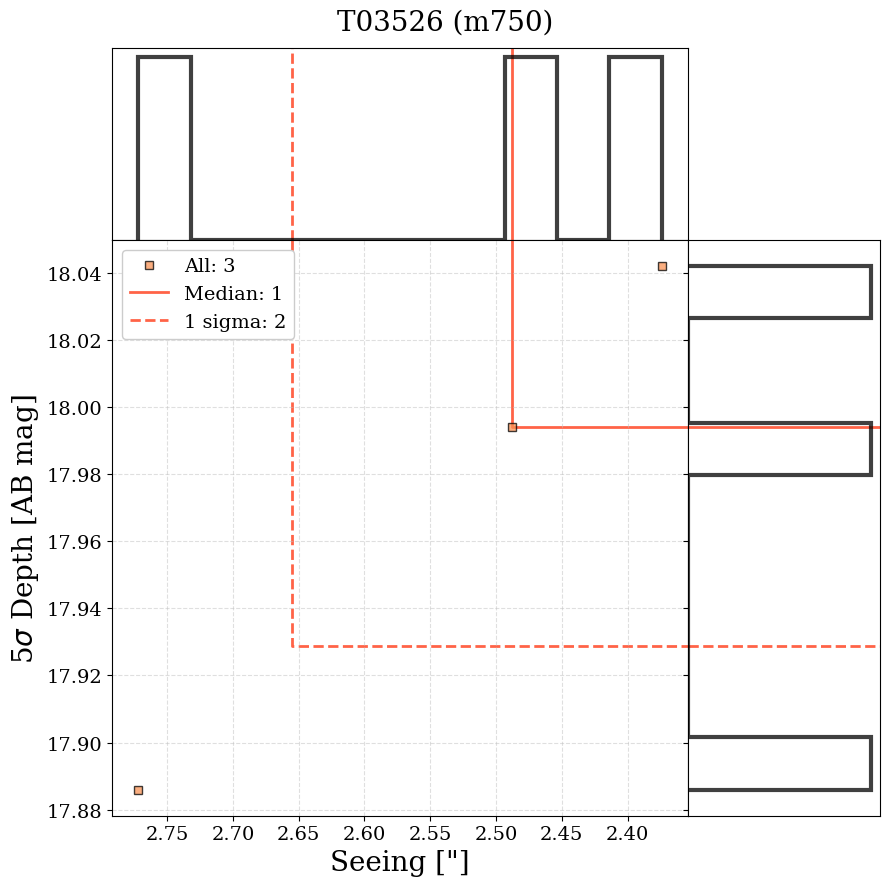

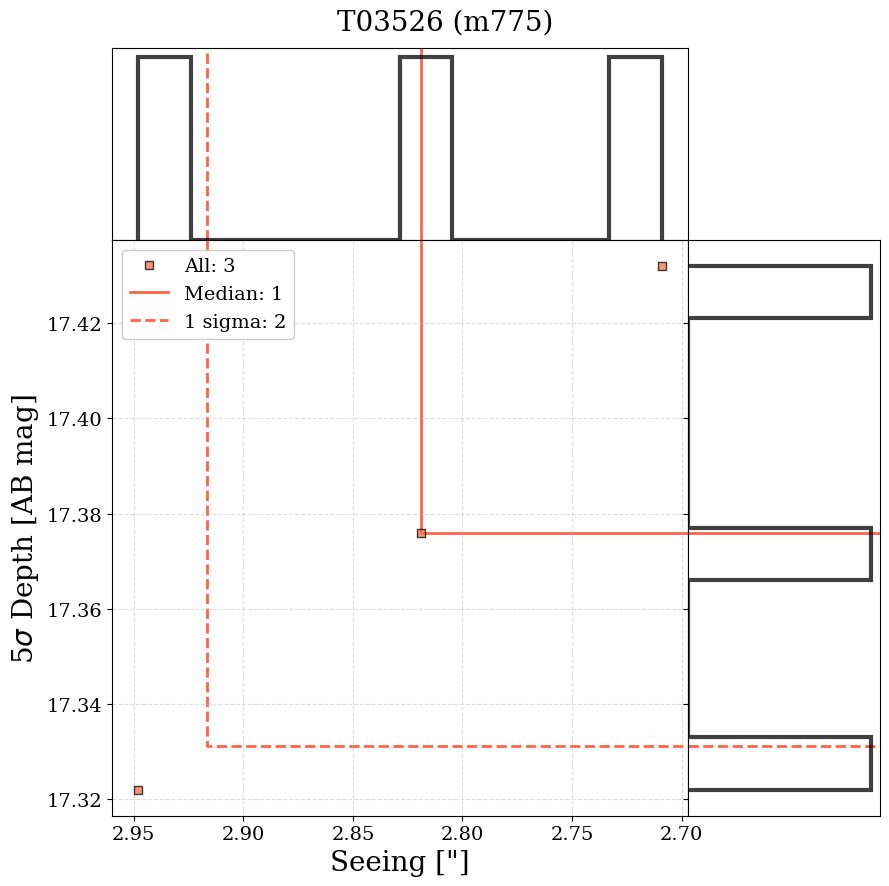

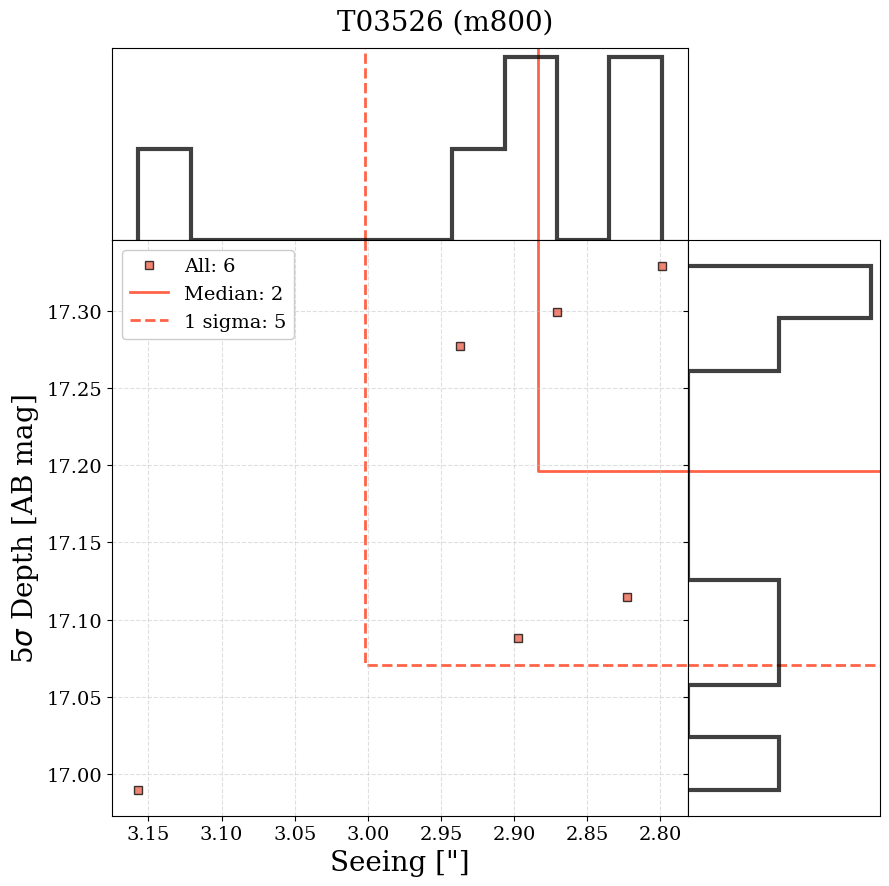

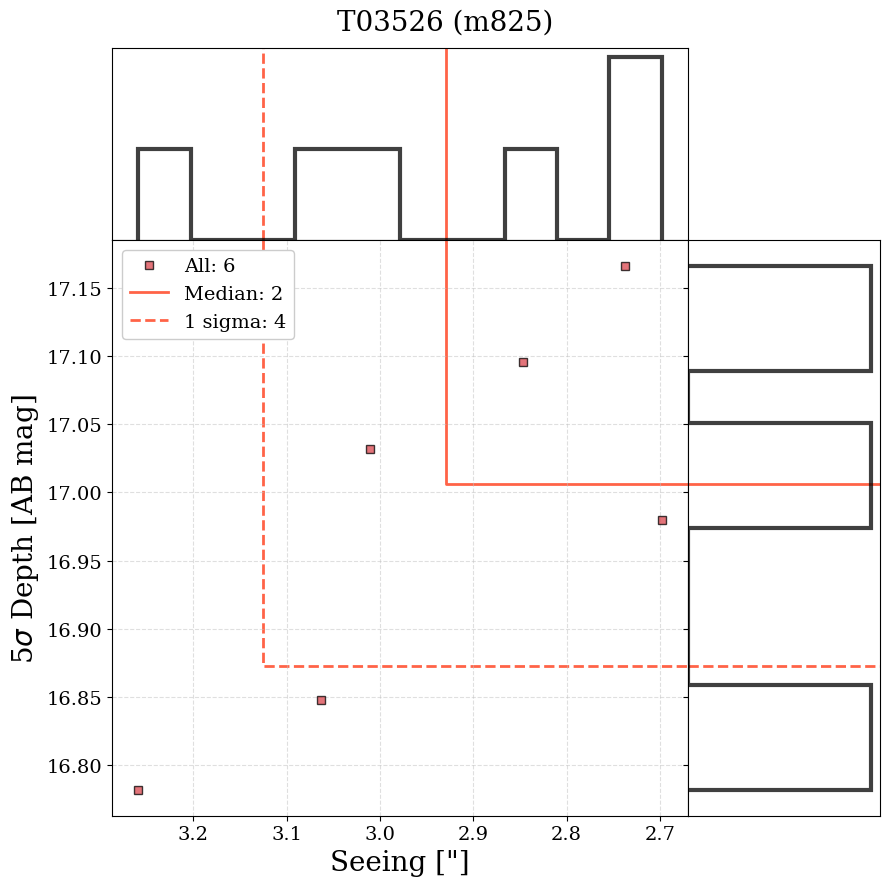

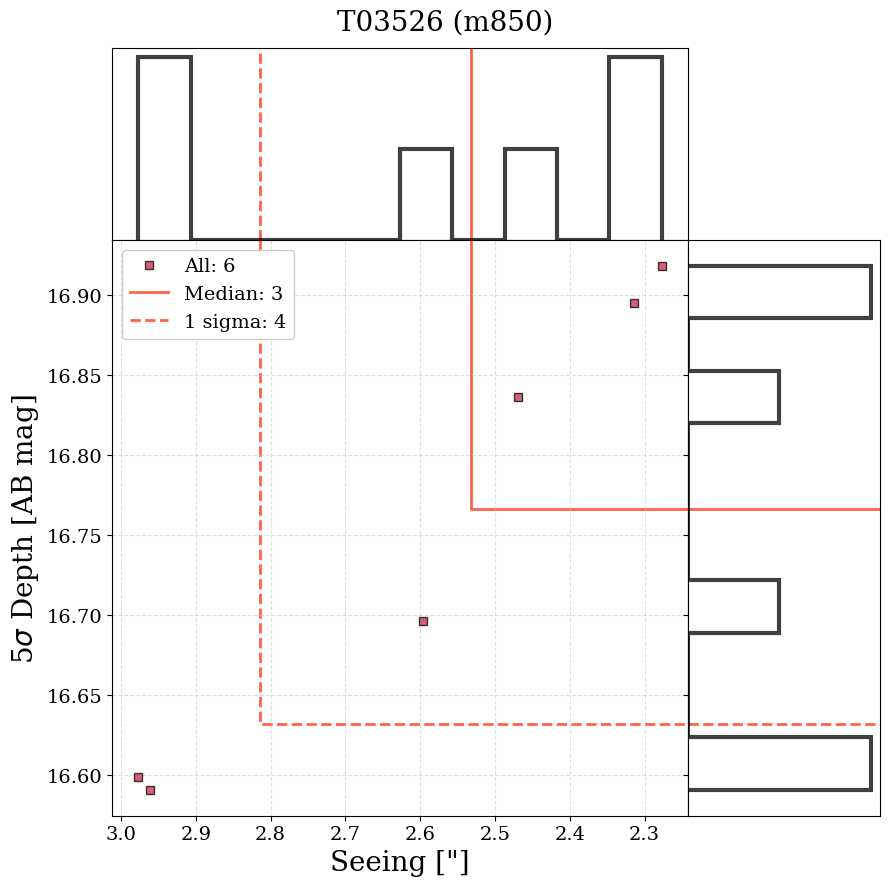

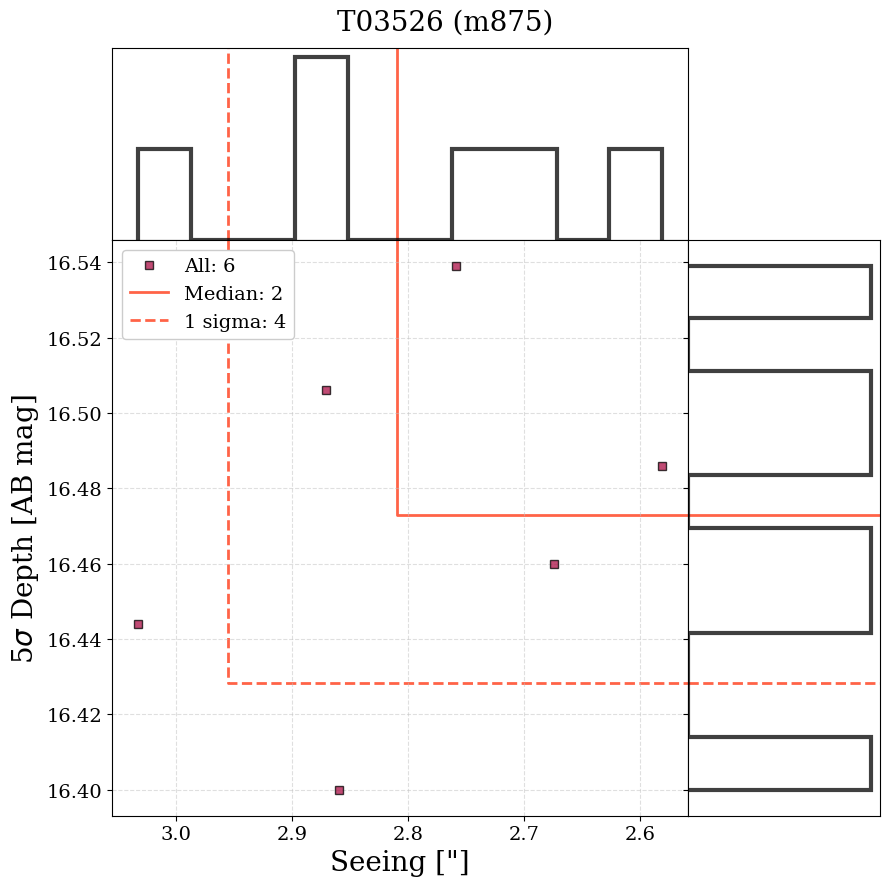

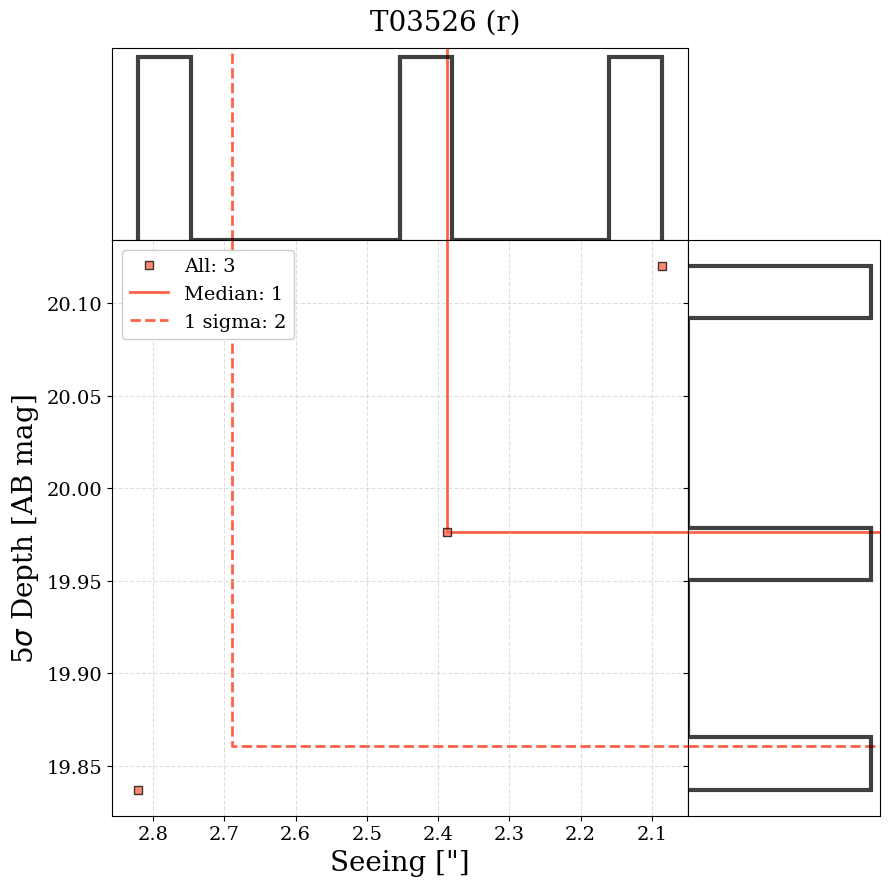

In [232]:
for ff, filte in tqdm(enumerate(result_table['filter'])):
	color = filter_color_palette_dict[filte]

	#	Path
	path_output = f"{path_save}/{obj}/{filte}"
	if not os.path.exists(path_output):
		os.makedirs(path_output)

	#	Images
	images = sorted(glob.glob(f"{path_data}/{obj}/*/{filte}/calib*0.fits"))
	if verbose: print(f"{len(images)} images found")

	#	Image Collection & Selection
	try:
		ic = ImageFileCollection(filenames=images)
		raw_table = ic.summary[columns_to_pick]

		bad_image_mask = ~raw_table['cd1_2'].mask
		table = raw_table[~raw_table['cd1_2'].mask]

		if verbose:
			print(f"All  images: {len(raw_table)}")
			print(f"Bad  images: {len(raw_table[~bad_image_mask])}")
			print(f"Good images: {len(table)}")

		for key in keys_to_check:
			table[key] = table[key].filled(np.nan).astype(float)

		#	Stat
		(seeing_median, seeing_std, seeing_min, seeing_max, depth_median, depth_std, depth_min, depth_max) = get_seeing_depth_stat(table=table, verbose=verbose)

		#	Index
		indx_median = (table['seeing'] < seeing_median) & (table['ul5_1'] > depth_median)
		indx_nsigma = (table['seeing'] < seeing_median + seeing_std) & (table['ul5_1'] > depth_median - depth_std)

		n_median_select = len(table[indx_median])
		n_nsigma_select = len(table[indx_nsigma])

		if verbose:
			print(f"Median Select : {n_median_select}")
			print(f"{n_sigma} Sigma Select: {n_nsigma_select}")

		#	Plot
		plot_seeing_depth_histogram(table, seeing_median, depth_median, n_sigma, n_median_select, n_nsigma_select, obj, filte, path_output, color=color)

		#	Result Tables
		#	median
		f = open(f"{path_output}/select_median.txt", "w")
		f.write("file\n")
		for inim in table['file'][indx_median].data:
			f.write(f"{inim}\n")
		f.close()
		#	N sigma
		g = open(f"{path_output}/select_{n_sigma}sigma.txt", "w")
		g.write("file\n")
		for inim in table['file'][indx_nsigma].data:
			g.write(f"{inim}\n")
		g.close()

		#	Result Table
		
		#	Number of Images
		result_table['n_all'][ff] = len(raw_table)
		result_table['n_bad'][ff] = len(raw_table[~bad_image_mask])
		result_table['n_image'][ff] = len(table)
		result_table['n_select_median'][ff] = len(table[indx_median])
		result_table['n_select_nsigma'][ff] = len(table[indx_nsigma])
		#	Stats
		result_table['seeing_median'][ff] = seeing_median
		result_table['seeing_std'][ff] = seeing_std
		result_table['seeing_min'][ff] = seeing_min
		result_table['seeing_max'][ff] = seeing_max
		result_table['depth_median'][ff] = depth_median
		result_table['depth_std'][ff] = depth_std
		result_table['depth_min'][ff] = depth_min
		result_table['depth_max'][ff] = depth_max
	except KeyError:
		print(f"[{filte}]: Key Error!")

In [233]:
for key in result_table.keys()[6:]: result_table[key].format = '1.3f'
result_table.write(f"{path_save}/{obj}/summary.csv", overwrite=True)
result_table

filter,n_all,n_bad,n_image,n_select_median,n_select_nsigma,seeing_median,seeing_std,seeing_min,seeing_max,depth_median,depth_std,depth_min,depth_max
str4,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
g,3,0,3,1,2,2.381,0.131,2.333,2.631,20.642,0.057,20.539,20.672
m400,3,0,3,1,2,3.505,0.281,3.169,3.857,19.025,0.086,18.917,19.128
m425,3,0,3,1,2,3.306,0.120,3.218,3.505,19.134,0.032,19.086,19.164
m450,3,0,3,1,2,2.954,0.231,2.675,3.240,19.240,0.072,19.139,19.314
m475,3,0,3,1,3,2.789,0.258,2.314,2.914,19.339,0.089,19.295,19.502
m500,3,0,3,0,2,2.576,0.155,2.561,2.898,19.552,0.061,19.423,19.552
m525,3,0,3,1,2,2.339,0.162,2.255,2.633,19.444,0.078,19.331,19.520
m550,3,0,3,1,2,2.677,0.051,2.606,2.731,18.949,0.023,18.922,18.978
m575,3,0,3,1,2,2.530,0.209,2.392,2.888,19.079,0.091,18.964,19.188
